In [1]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
import pandas as pd
import numpy as np
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pylab as plt

import seaborn as sns

# Table of Contents
>## 1. ANOVA
* 1.1. Definitions
* 1.2. TSS = ESS + RSS
* 1.3. ANOVA - `RegressionResult`
* 1.4. ANOVA Table
* 1.5. ANOVA - Models without Bias ($\bar{y}=0$
* 1.6. ANOVA - Models with Categorical Variable

>## 2. Model Selection
* 2.1. Coefficient of Determination, $R^2$
* 2.2. Adjusted Coefficient of Determination
* 2.3. F-test
* 2.4. Information Criterion

>## 3. Model Diagnosis
* 3.1. Normality Test
* 3.2. Heteroskedasticity
* 3.3. Autocorrelation Coefficient

>## 4. Model Improvements
* 4.1. Conditional Number
* 4.2. Scaling
* 4.3. Variable Transformation
* 4.4. Remove Outliers
* 4.5. Multicolinearity
* 4.6. Remove Dependent Variables - VIF

# 1. ANOVA
* RSS: Residual Sum of Squares $\rightarrow$ cannot work as a performance metric since it is scale-dependent
* **ANOVA**: Analysis of Variance

## 1.1. Definitions

#### Sample Mean
$$\bar{y}=\frac{1}{N}\sum_{i=1}^N y_i $$

#### TSS (Total Sum of Squares)
* Fluctuation of $y$
$$\text{TSS} = \sum_{i=1}^N (y_i-\bar{y})^2 = (y - \bar{y})^T(y - \bar{y} )$$

#### ESS (Explained Sum of Squares)
* Fluctuation of $\hat{y}$
$$\text{ESS}=\sum_{i=1}^N (\hat{y}_i -\bar{\hat{y}})^2 = (\hat{y} - \bar{\hat{y}})^T(\hat{y} - \bar{\hat{y}})$$

#### RSS (Residual Sum of Squares)
$$\text{RSS}=\sum_{i=1}^N (y_i - \hat{y}_i)^2\ = e^Te$$

## 1.2. TSS = ESS + RSS
* If the model is correctly defined,

$$ \bar{e} = \bar{y} - \bar{\hat{y}} = 0$$

$$ \bar{y} = \bar{\hat{y}} $$

* And the following relationship is satisfied

$$\text{TSS} = \text{ESS} + \text{RSS}$$

#### Proof)

$$ y = X\hat{w} + e = \hat{y} + e $$

$$ y - \bar{y} = \hat{y} - \bar{y} + e = (X- \bar{X})\hat{w} + e $$

* $X,\bar{X}$ and $e$ are normal

$$ X^Te = \bar{X}^Te = 0 $$

* Then, we can derive the following:

$$
\begin{eqnarray}
\text{TSS} 
&=& (y - \bar{y})^T(y - \bar{y} ) \\
&=& (\hat{y} - \bar{y} + e)^T(\hat{y} - \bar{y} + e) \\
&=& (\hat{y} - \bar{y})^T(\hat{y} - \bar{y}) + e^Te + 2(\hat{y} - \bar{y})^Te \\
&=& (\hat{y} - \bar{y})^T(\hat{y} - \bar{y}) + e^Te + 2\hat{w}^T(X - \bar{X})^Te \\
&=& (\hat{y} - \bar{y})^T(\hat{y} - \bar{y}) + e^Te \\
&=& \text{ESS} + \text{RSS}
\end{eqnarray}
$$

## 1.3. ANOVA - `RegressionResult`

In [56]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

In [57]:
print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared)

TSS =  291345.75789830607
ESS =  188589.61349210917
RSS =  102754.33755137534
ESS + RSS =  291343.9510434845
R squared =  0.6473091780922585


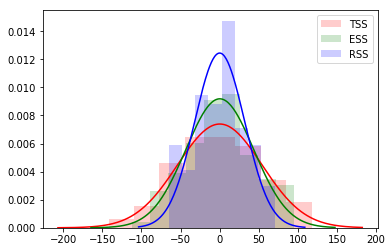

In [58]:
sns.distplot(y, 
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"}, 
             label="TSS")
sns.distplot(result.fittedvalues, 
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"}, 
             label="ESS")
sns.distplot(result.resid, 
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"}, 
             label="RSS")
plt.legend()
plt.show()

## 1.4. ANOVA Table
* $N$: no. of samples
* $K$: no. of parameters


| source | degree of freedom | sum of square | mean square  | F test-statstics | p-value |
|-|-|-|-|-|-|
| Regression| $$K-1$$ | $$\text{ESS}$$ | $$s_{\hat{y}}^2 = \dfrac{\text{ESS}}{K-1}$$   | $$F=\dfrac{s_{\hat{y}}^2}{s_e^2} $$ | p-value |
| Residual | $$N-K$$  | $$\text{RSS}$$  | $$s_e^2= \dfrac{\text{RSS}}{N-K}$$ | |
| Total     | $$N-1$$  | $$\text{TSS}$$ | $$s_y^2= \dfrac{\text{TSS}}{N-1}$$ | |
| $R^2$   |    |  $$\text{ESS} / \text{TSS}$$ |  | |

#### ANOVA Table & F-test - `statsmodels`
* Use `anova_lm` command (in order to do this, the model should be made using `from_formula` method

In [59]:
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,188589.613492,188589.613492,179.863766,6.601482e-24
Residual,98.0,102754.337551,1048.513648,NaN,NaN


In [60]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     179.9
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           6.60e-24
Time:                        15:58:52   Log-Likelihood:                -488.64
No. Observations:                 100   AIC:                             981.3
Df Residuals:                      98   BIC:                             986.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4425      3.244     -0.753      0.4

## 1.5. ANOVA - Models without Bias ($\bar{y}=0$)
* Definition of TSS:
  * By assuming $\bar{y}=0$, even if it is not (else, $TSS = RSS + ESS$ would not hold true)

$$\text{TSS} = \sum_i y_i^2 = y^Ty $$

* Hence, the model with bias & the model w/o bias should not be directly compared

In [62]:
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

In [63]:
result2.rsquared

0.18768724705943896

## 1.6. ANOVA - Models with Categorical Variable

* **One-Way ANOVA**: calculates the influence of each category

* **BSS**(alternative for ESS): Between-Group Variance
  $$ BSS = \sum_{k=1}^K N_k (\bar{y}_k - \bar{y})^2 $$

* **WSS**(alternative for RSS): Within-Group Variance
  $$ WSS = \sum_{i}^N (\bar{y}_k - y_{i})^2 $$

* **TSS**
  $$ TSS = \sum_{i}^N (y_{i} - \bar{y})^2 $$

* **ANOVA Table**

| source | degree of freedom | sum of square | mean square  | F test-statstics | p-value |
|-|-|-|-|-|-|
| Between  | $$K-1$$ | $$\text{BSS}$$ | $$s_{\hat{y}}^2 = \dfrac{\text{ESS}}{K-1}$$   | $$F=\dfrac{s_{\hat{y}}^2}{s_e^2} $$ | p-value |
| Within   | $$N-K$$  | $$\text{WSS}$$  | $$s_e^2= \dfrac{\text{RSS}}{N-K}$$ | |
| Total     | $$N-1$$  | $$\text{TSS}$$ | $$s_y^2= \dfrac{\text{TSS}}{N-1}$$ | |
| $R^2$   |    |  $$\text{BSS} / \text{TSS}$$ |  | |

* F-test
  * Null Hypothesis: coefficient for every dummy variable is 0 (the variable is irrelevant)
  * i.e. $\text{BSS}=0$ and $\text{WSS}=\text{TSS}$

### Example - `CHAS` variable in Boston House Prices dataset

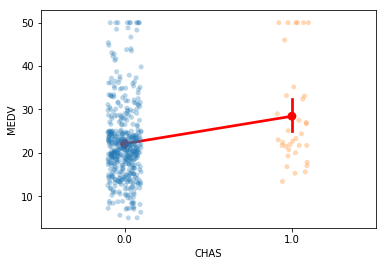

In [15]:
sns.stripplot(x="CHAS", y="MEDV", data=df_boston, jitter=True, alpha=.3)
sns.pointplot(x="CHAS", y="MEDV", data=df_boston, dodge=True, color='r')
plt.show()

In [67]:
model_chas = sm.OLS.from_formula("MEDV ~ C(CHAS) + 0", data=df_boston)
sm.stats.anova_lm(model_chas.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(CHAS),2.0,258222.123856,129111.061928,1571.626788,2.495018e-217
Residual,504.0,41404.216144,82.151223,NaN,NaN


# 2. Model Selection

## 2.1. Coefficient of Determination, $R^2$

$$R^2 \equiv 1 - \dfrac{\text{RSS}}{\text{TSS}}\ = \dfrac{\text{ESS}}{\text{TSS}}\ $$

$$0 \leq R^2  \leq 1$$

* $R^2 = 0$: the result is meaningless
* $R^2 = 1$: the result is perfect

### $R^2$ and $r^2$
* The correlation coefficient between $y$ and $\hat{y}$: $r$ $\rightarrow$ $r^2 = R^2$

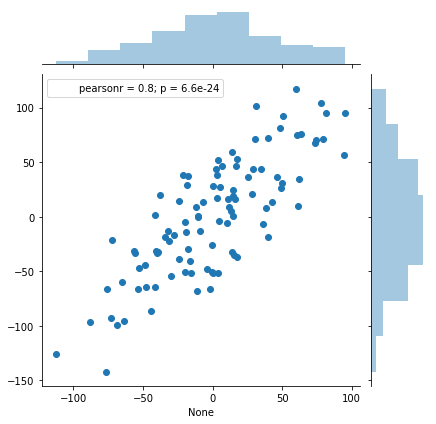

In [61]:
sns.jointplot(result.fittedvalues, y)
plt.show()

## 2.2. Adjusted Coefficient of Determination

* As more variables are taken into account, $R^2$ increases

>**proof**
>
> Let's say that we are adding a new variable $z$, then
>
>  $$ R^2_{Xz} = R^2_{X} + (1-R^2_{X})r^{\ast 2}_{yz} $$
>
> Where,
>
> $r^{\ast 2}_{yz}$: correlation coefficient of $z$ and $y$
>
> Since all three terms are $ \geq 0$
>
> $$R^2_{Xz} \geq R^2_{X} $$

* Thus, $R_{adj}^2$ has been introduced (give penalty for large $K$)

$$ R_{adj}^2 = 1 - \frac{n-1}{n-K}(1-R^2) = \dfrac{(n-1)R^2 +1-K}{n-K} $$

## 2.3. F-test
* Null Hypothesis: $w_i=0$ $\rightarrow$ $H_0:R^2=0$
* $\hat{w}$: follows normal distribution
* $\hat{y} = \hat{w}^T x$: linear combination of normal distribution $\rightarrow$ normal distribution
* Residual: linear transformation of disturbance $\rightarrow$ normal distribution

  * $\rightarrow$ the following ratio follows **F-distribution**
  
$$ \dfrac{\text{ESS}}{K-1} \div  \dfrac{\text{RSS}}{N-K} \sim F(K-1, N-K) $$
* Use this value as test statistic for F-test

### Comparison between Models

* **Full Model**: $ y = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3 $
* **Reduced Model**: $ y = w_0 + w_1 x_1 $

>* Null Hypothesis: the two models are essentially the same
$$ H_0: w_2 = w_3 = 0 $$

* **`anova_lm` command - insert reduced model & full model as parameters**

In [64]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
dfX_boston = sm.add_constant(dfX0_boston)
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [65]:
model_full = sm.OLS.from_formula("MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula("MEDV ~ CRIM + ZN + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,11082.941389,0.0,NaN,NaN,NaN
1,492.0,11080.276284,2.0,2.665105,0.05917,0.942554


### Comparison between Variables

* **Full Model** vs. **Full Model w/o a Variable**

In [66]:
model_full = sm.OLS.from_formula("MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula("MEDV ~ ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,493.0,11322.004277,0.0,NaN,NaN,NaN
1,492.0,11080.276284,1.0,241.727993,10.733502,0.001126


* **`anova_lm` - Set `typ=2` to repeat this process for every variable**

In [14]:
model_boston = sm.OLS.from_formula("MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
result_boston = model_boston.fit()
sm.stats.anova_lm(result_boston, typ=2)

,sum_sq,df,F,PR(>F)
CRIM,241.727993,1.0,10.733502,1.126402e-03
ZN,257.226157,1.0,11.421671,7.836070e-04
INDUS,2.591314,1.0,0.115063,7.345971e-01
NOX,488.605951,1.0,21.695680,4.117296e-06
RM,1865.902935,1.0,82.852108,2.207486e-18
AGE,0.072792,1.0,0.003232,9.546859e-01
DIS,1232.544417,1.0,54.728947,6.017651e-13
RAD,478.172457,1.0,21.232399,5.189664e-06
TAX,242.053549,1.0,10.747958,1.117826e-03
PTRATIO,1195.939414,1.0,53.103567,1.268218e-12


* NOTE: the result is same as the p-value for t-test
$$ t_n^2 = F_{(1, n)} $$

## 2.4. Information Criterion
* Estimators of the **relative quality** of models (the smaller the better)
* **AIC**(Akaike Information Criterion)
 
$$ \text{AIC} = -2\log L + 2K $$

* **BIC**(Bayesian Information Criterion

$$ \text{BIC} = -2\log L + K\log n $$

# 3. Model Diagnosis

## 3.1. Normality Test

* Residuals should follow **normal distribution** $\rightarrow$ else, there is a problem

### Case 1. Normality Test: Fail

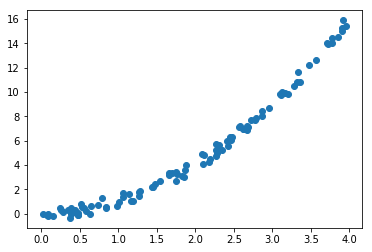

In [108]:
def make_regression2(n_sample = 100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y

x2, y2 = make_regression2()
plt.scatter(x2, y2)
plt.show()

In [109]:
dfX20 = pd.DataFrame(x2, columns=["X1"])
dfX2 = sm.add_constant(dfX20)
dfy2 = pd.DataFrame(y2, columns=["y"])

model2 = sm.OLS(dfy2, dfX2)
result2 = model2.fit()

#### This model fails the normality test

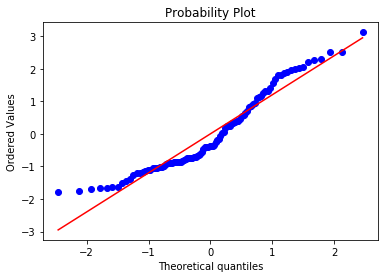

In [110]:
# make a QQ plot
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [111]:
test = sms.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


### Case 2. Normality Test: Pass $\rightarrow$ Plot Residual vs. Variables

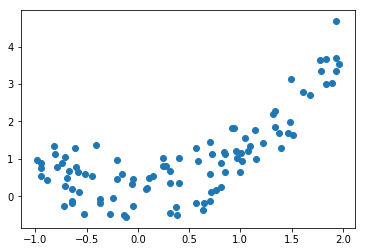

In [112]:
def make_regression3(n_sample = 100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y

x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show()

In [113]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

#### This model passes the normality test

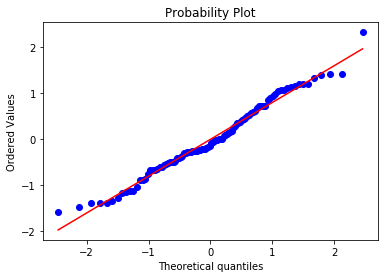

In [114]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()

In [115]:
test = sms.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  1.202
P-value     :  0.548


#### Yet, it can be seen that the residuals have a non-linear relationship with the variable, `X1`

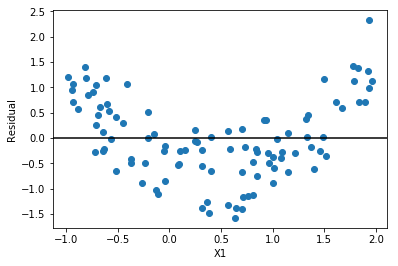

In [77]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

## 3.2. Heteroskedasticity
* $VAR[y]$ increases as $X$ increases $\rightarrow$ heteroskedasticity occurs
* Such problem is often solved by using **translog model**

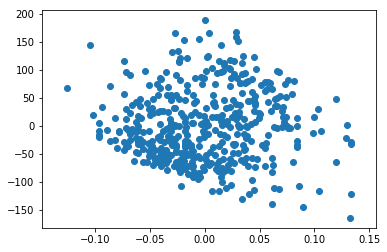

In [116]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
df = pd.concat([pd.DataFrame(diabetes.data, columns=["x%d" % (i + 1) for i in range(diabetes.data.shape[1])]),
                pd.DataFrame(diabetes.target, columns=["target"])],
               axis=1)
model = sm.OLS.from_formula("target ~ x9", data=df)
result = model.fit()
plt.scatter(df["x9"], result.resid)
plt.show()

## 3.3. Autocorrelation Coefficient
* Treat residual as **time-series** $\rightarrow$ if the residuals are mutually independent, autocorrelation coefficient, $\rho_l=0$
* Following tests can be used
  * **Box-Pierce test**
  * **Ljung-Box test**
  * **Durbin-Watson test**
* Null Hypothesis: 
$$ H_0: \rho_l = 0 \;\;\;\text{ for } i = 1, 2, \cdots, l $$

# 4. Model Improvements

## 4.1. Conditional Number
* The ratio between max & min eigenvalues of the covariance matrix, $X^TX$

$$ \text{condition number} = \dfrac{\lambda_{\text{max}}}{\lambda_{\text{min}}} $$

* If this value is large $\rightarrow$ the model is sensitive to errors in data
* **Reasons for large Conditional Number**
  * 1) Huge difference in the size of the variables $\rightarrow$ solve with **scaling**
  * 2) Multi-colinearity (there are correlated variables) $\rightarrow$ solve with dimension reduction techniques like **PCA**

#### Example - Matrix with Small Conditional Number

* Consider the following equality,

$$ Ax = b $$

In [117]:
A = np.eye(4)

In [118]:
b = np.ones(4)
sp.linalg.solve(A, b)

array([1., 1., 1., 1.])

In [119]:
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([0.99990001, 0.99990001, 0.99990001, 0.99990001])

#### Example - Matrix with High Conditional Number

In [120]:
A = sp.linalg.hilbert(4)
A

array([[1.        , 0.5       , 0.33333333, 0.25      ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

In [121]:
np.linalg.cond(A)

15513.738738929662

In [84]:
sp.linalg.solve(A, b)

array([  -4.,   60., -180.,  140.])

In [85]:
sp.linalg.solve(A + 0.0001 * np.eye(4), b)

array([ -0.58897672,  21.1225671 , -85.75912499,  78.45650825])

## 4.2. Scaling
* Simply use `scale` command in `StatsModels`
* Same scaling is applied when using `predict` command
* Example:

```python
from sklearn.datasets import load_boston
boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("MEDV ~ scale(CRIM) + scale(ZN) + scale(INDUS) + scale(LSTAT) + CHAS", data=df)
result = model.fit()
print(result.summary())
```

## 4.3. Variable Transformation
* Apply transformations such as `np.log()`, `I(x**2)`, `np.sqrt()`, ...
* Example:

```python
model3 = sm.OLS.from_formula("np.log(MEDV) ~ scale(I(CRIM ** 2)) + scale(np.log(DIS)) + CHAS", data=df)
result3 = model3.fit()
print(result3.summary())
```

## 4.4. Remove Outliers
* Remove outliers based on **fox recommendation for cook's distance**
* Example

```python
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(df) - 2)
idx_outlier = np.where(cooks_d2 > fox_cr)[0]

idx = list(set(range(len(df))).difference(idx_outlier))
df_new = df.iloc[idx, :].reset_index(drop=True)

model_new = sm.OLS.from_formula("np.log(MEDV) ~ scale(CRIM) + ... + CHAS", data=df_new)
result_new = model_new.fit()
print(result_new.summary())

```

## 4.5. Multicolinearity
* Some variables can be represented as a combination of other variables
* Disobeys the condition that the covariance matrix has to be full rank

#### Example of High Multicolinearity
* List of Variables:
  * TOTEMP - Total Employment
  * GNPDEFL - GNP deflator
  * GNP - GNP
  * UNEMP - Number of unemployed
  * ARMED - Size of armed forces
  * POP - Population
  * YEAR - Year (1947 - 1962)
  
#### The pairplot shows that the variables are highly correlated 

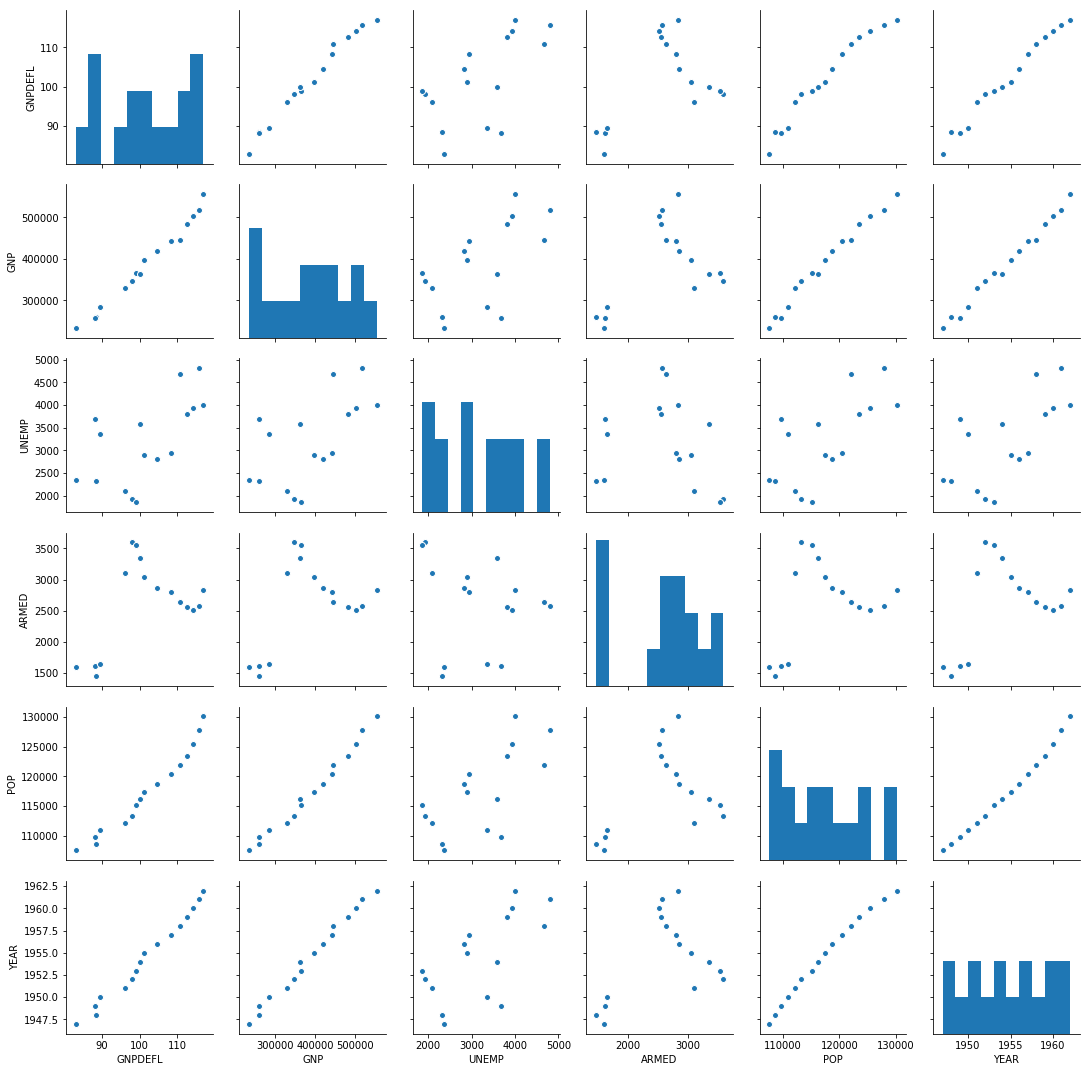

In [127]:
from statsmodels.datasets.longley import load_pandas
dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

#### Correlation coefficients are also very high

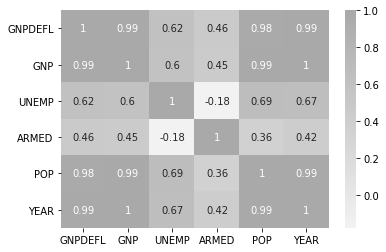

In [97]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

#### First, reduce conditional number by scaling the variables

In [128]:
model = sm.OLS.from_formula("TOTEMP ~ "
                            "scale(GNPDEFL) + scale(POP) + scale(GNP) + "
                            "scale(YEAR) + scale(ARMED) + scale(UNEMP)", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Thu, 26 Jul 2018   Prob (F-statistic):           4.98e-10
Time:                        01:13:34   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.532e+04     76.214    857.

#### Possible Solutions include:
* Delete some variables
* PCA
* Regularization

## 4.6. Remove Dependent Variables - VIF
* VIF(Variance Inflation Factor) - Compare the performance of `"x_i ~ other variables"` for different $i$
* Smaller the better

$$ \text{VIF}_i = \frac{\sigma^2}{(n-1)\text{Var}[X_i]}\cdot \frac{1}{1-R_i^2} $$

#### Use `variance_inflation_factor` command in `StatsModels`
* Based on VIF, choose GNP, ARMED, UNEMP $\rightarrow$ achieve similar performance

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR
